#  Insurance charges prediction - ML Project

- Exploratory data analysis (EDA) section

- Multiple regression models (Linear, Polynomial, Ridge, Lasso, Random Forest)

- Cross-validation

- Log-transform regression

- Model comparison plots, residuals, and feature importances


In [1]:
# =====================================================
#  1. Import Libraries
# =====================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model, metrics, preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline
plt.style.use('seaborn-v0_8')

## Load Dataset

In [2]:
# =====================================================
#  2. Load Dataset
# =====================================================
for dirname, _, filenames in os.walk('/kaggle/input/insurance/'):
    for filename in filenames:
        mydataset = os.path.join(dirname, filename)

data = pd.read_csv(mydataset)
print("Dataset shape:", data.shape)
display(data.head())



Dataset shape: (1338, 7)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Data Overview

In [3]:
# Summary statistics for numerical features
data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


**Outlier Insights**


**1. Age - No obvious outliers.**

Range: 18 → 64 years — within realistic limits.
 

**2. BMI**

Mean = 30.66 (slightly obese range).

75th percentile = 34.69, max = 53.13  ( that’s quite high ).

Using the IQR rule:

IQR = 34.69 - 26.30 = 8.39
Upper Bound = 34.69 + 1.5*8.39 = 47.28


! Values above 47.28 are considered potential BMI outliers (though still physiologically possible.)

**3. Children - All values plausible, no outliers.**


**4. Charges**

Mean = \\$13,270, Std = \\$12,110 (very high variability).

75th percentile = \\$16,640, max = \\$63,770.

IQR = 16,640 − 4,740 = 11,900
Upper Bound = 16,640 + 1.5×11,900 = \\$34,490

! So all charges above \\$34,490 are statistical outliers — but likely meaningful (e.g., heavy smokers or severe medical cases).

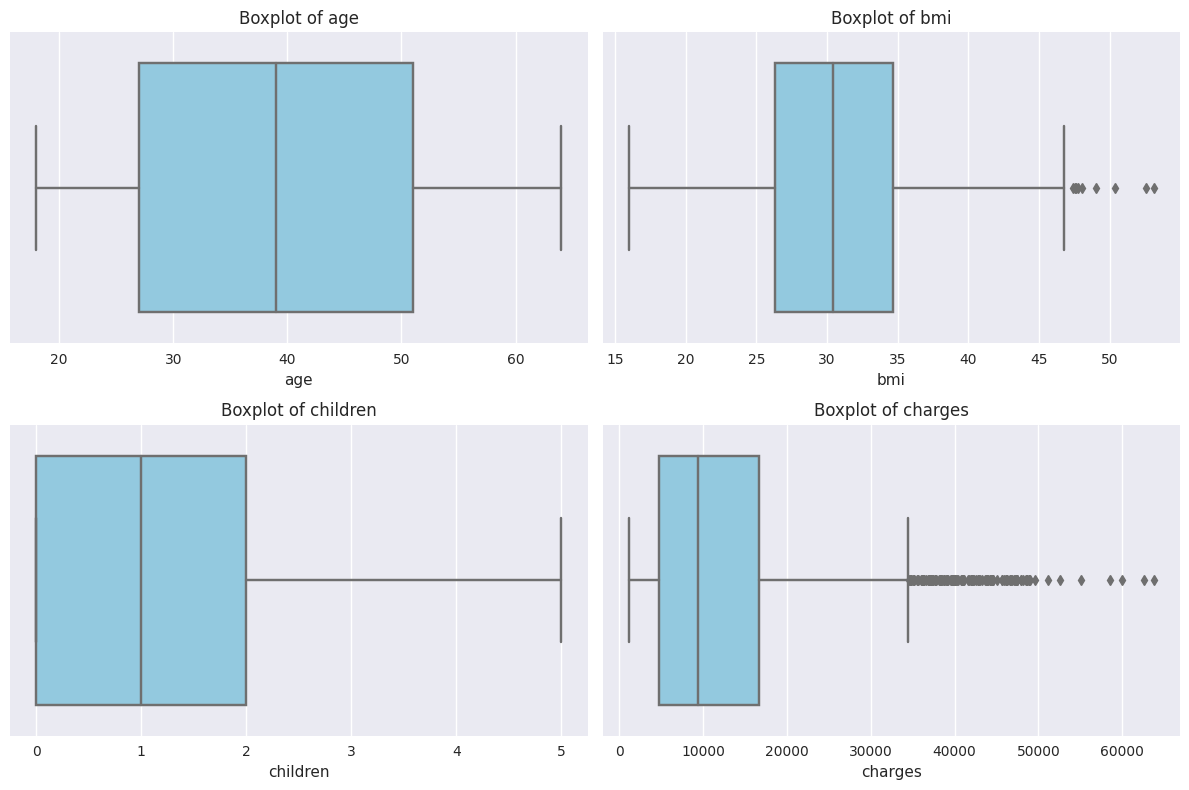

In [4]:
num_cols = ['age', 'bmi', 'children', 'charges']

plt.figure(figsize=(12, 8))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=data[col], color='skyblue')
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

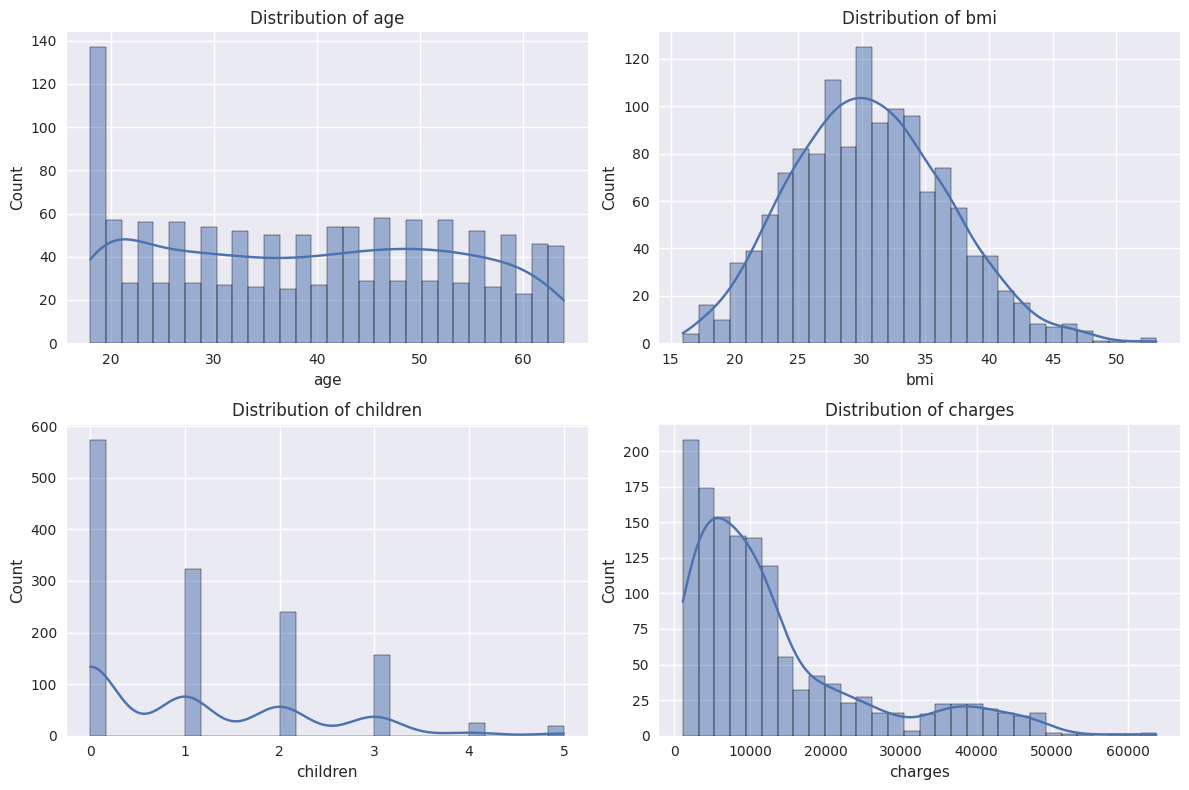

In [5]:
# Histograms or KDE plots — to check skewness
plt.figure(figsize=(12, 8))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 2, i)
    sns.histplot(data[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()


In [6]:
# Statistical Detection Using the IQR Method

def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    print(f'{column}: {len(outliers)} outliers')
    return outliers

for col in num_cols:
    detect_outliers_iqr(data, col)


age: 0 outliers
bmi: 9 outliers
children: 0 outliers
charges: 139 outliers


In [7]:
# Z-Score Method (Alternative)

from scipy import stats
z_scores = np.abs(stats.zscore(data[num_cols]))
outliers = (z_scores > 3).sum(axis=0)
print("Number of outliers (|Z| > 3) per column:")
print(outliers)

Number of outliers (|Z| > 3) per column:
age          0
bmi          4
children    18
charges      7
dtype: int64


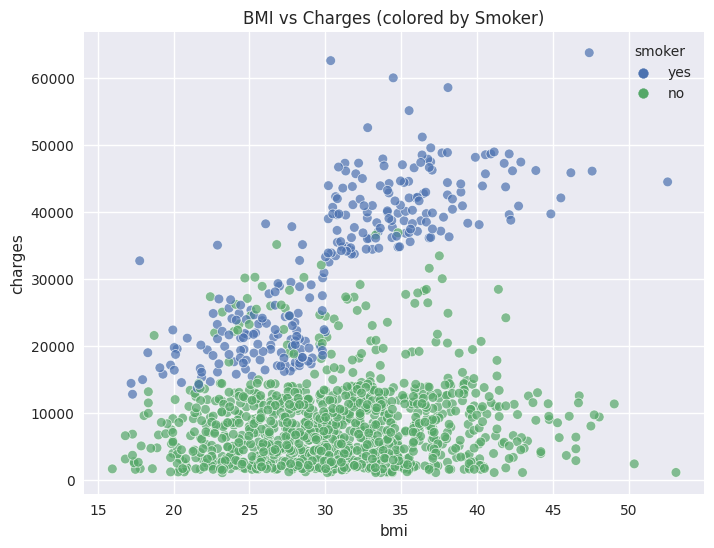

In [8]:
# Feature Interaction

plt.figure(figsize=(8,6))
sns.scatterplot(x='bmi', y='charges', hue='smoker', data=data, alpha=0.7)
plt.title('BMI vs Charges (colored by Smoker)')
plt.show()

In [9]:
# Optional: cap extreme values in 'charges'
Q1, Q3 = data['charges'].quantile([0.25, 0.75])
IQR = Q3 - Q1
upper_cap = Q3 + 1.5 * IQR
data['charges'] = np.where(data['charges'] > upper_cap, upper_cap, data['charges'])


### Interpretation and Insights

- The charges variable is clearly right-skewed, with a long tail of high values.
These are not necessarily data errors, but meaningful high-cost insurance claims — typically linked to smokers or severe conditions.

- The BMI outliers are few and plausible — We can keep them, but they may slightly affect regression-based models that are sensitive to extreme values.

- The dataset overall is clean and realistic.

## Data Preprocessing

In [10]:
# Encode binary categorical features
data['smoker'] = data['smoker'].apply(lambda x: 0 if x == 'no' else 1)
data['sex'] = data['sex'].apply(lambda x: 0 if x == 'female' else 1)

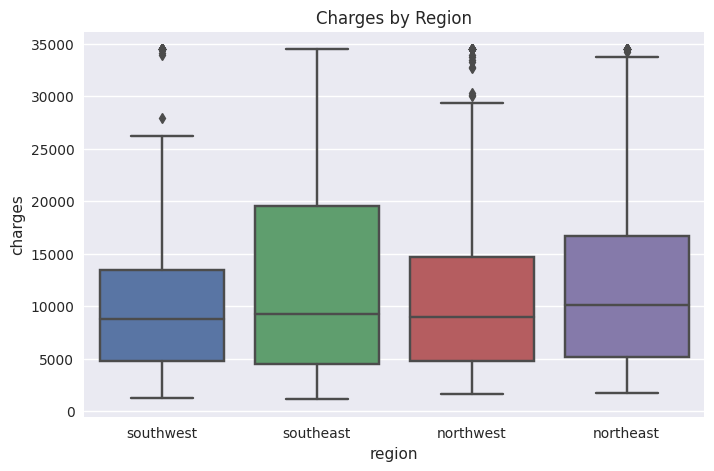

In [11]:
plt.figure(figsize=(8,5))
sns.boxplot(x='region', y='charges', data=data)
plt.title('Charges by Region')
plt.show()


In [12]:
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,southwest,16884.92400
1,18,1,33.770,1,0,southeast,1725.55230
2,28,1,33.000,3,0,southeast,4449.46200
3,33,1,22.705,0,0,northwest,21984.47061
4,32,1,28.880,0,0,northwest,3866.85520


In [13]:

# One-hot encode remaining categorical variables
data = pd.get_dummies(data, drop_first=False)


In [14]:
#column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
#data = pd.read_csv(mydataset, header=None, delimiter=r"\s+") #, names=column_names)
#data = pd.read_csv(mydataset)
data.head()

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,False,False,False,True
1,18,1,33.770,1,0,1725.55230,False,False,True,False
2,28,1,33.000,3,0,4449.46200,False,False,True,False
3,33,1,22.705,0,0,21984.47061,False,True,False,False
4,32,1,28.880,0,0,3866.85520,False,True,False,False


In [15]:
display(data.dtypes)

age                   int64
sex                   int64
bmi                 float64
children              int64
smoker                int64
charges             float64
region_northeast       bool
region_northwest       bool
region_southeast       bool
region_southwest       bool
dtype: object

## Exploratory Data Analysis (EDA)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


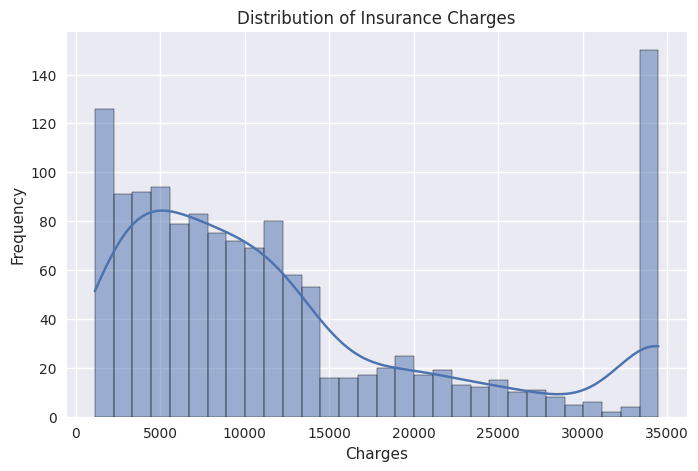

In [16]:
#  Distribution of target variable (Charges)
plt.figure(figsize=(8,5))
sns.histplot(data['charges'], kde=True, bins=30)
plt.title('Distribution of Insurance Charges')
plt.xlabel('Charges')
plt.ylabel('Frequency')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


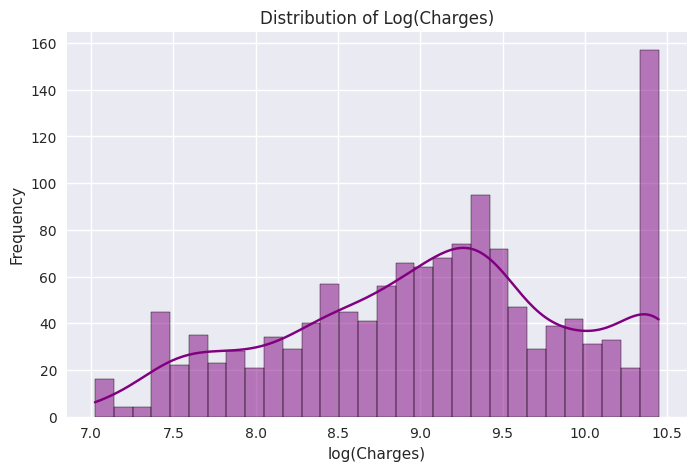

In [17]:
# Log-scale version
plt.figure(figsize=(8,5))
sns.histplot(np.log1p(data['charges']), kde=True, bins=30, color='purple')
plt.title('Distribution of Log(Charges)')
plt.xlabel('log(Charges)')
plt.ylabel('Frequency')
plt.show()

In [18]:
from scipy.stats import skew, kurtosis

print(f"Skewness: {skew(data['charges']):.2f}")
print(f"Kurtosis: {kurtosis(data['charges']):.2f}")

Skewness: 1.08
Kurtosis: 0.01


**Observation:**

- Right-skewed (Skewness > 1) → Linear and polynomial regression models may be affected by extreme high values.

The model will try to “fit” these high charges, which can inflate errors on lower/mid-range values.

- Kurtosis < 3 → Not heavy-tailed, but combined with the right skew, we still have extreme high charges to handle.

**Conclusion:**

- Apply log transformation (log1p(charges)) for linear, polynomial, Ridge, and Lasso models.

- Keep the original charges for Random Forest or tree-based models, since they are robust to skewness.

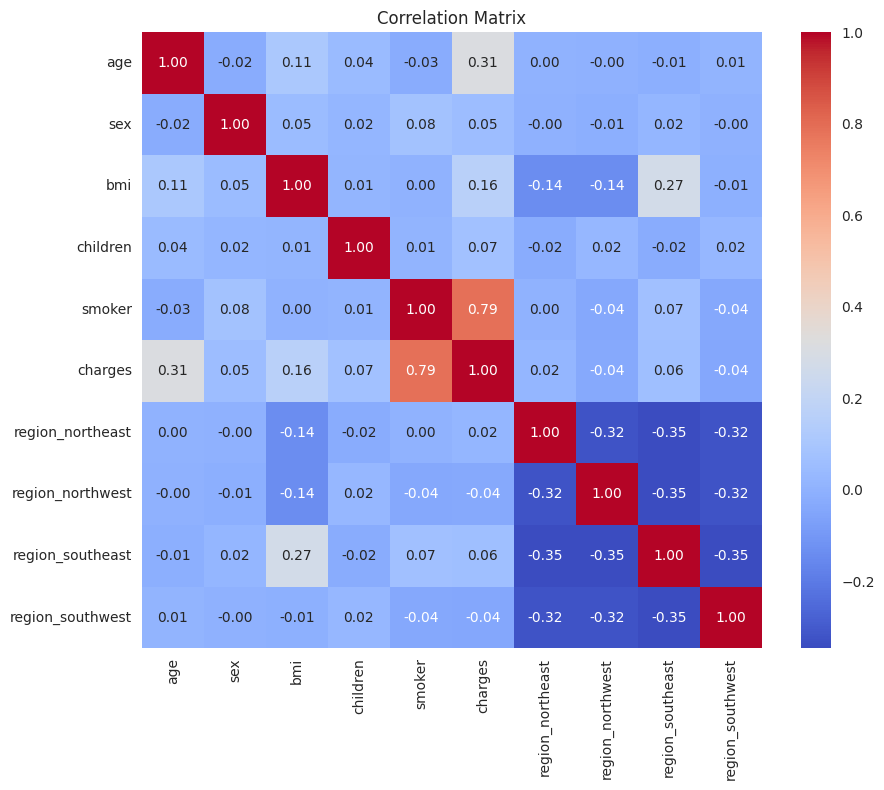

In [19]:
#  Correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

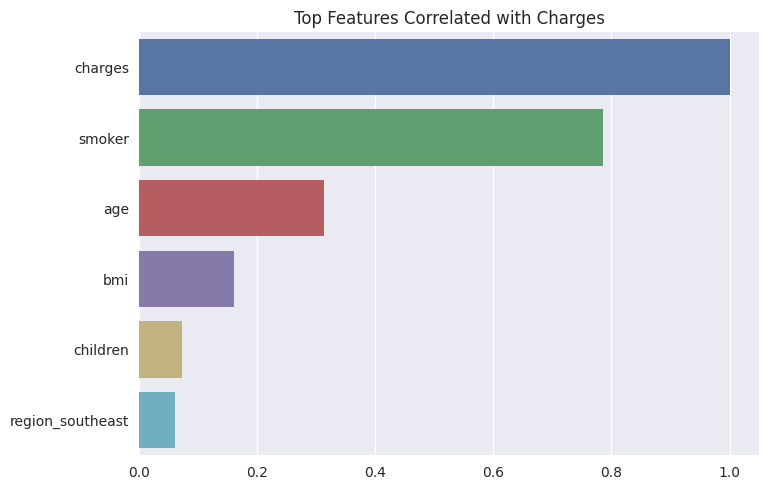

In [20]:
#  Top correlated features with charges
top_corr = data.corr()['charges'].sort_values(ascending=False).head(6)
sns.barplot(x=top_corr.values, y=top_corr.index)
plt.title('Top Features Correlated with Charges')
plt.show()



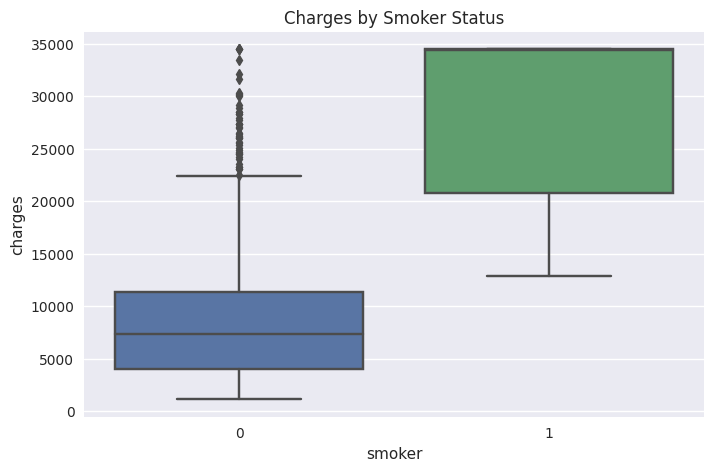

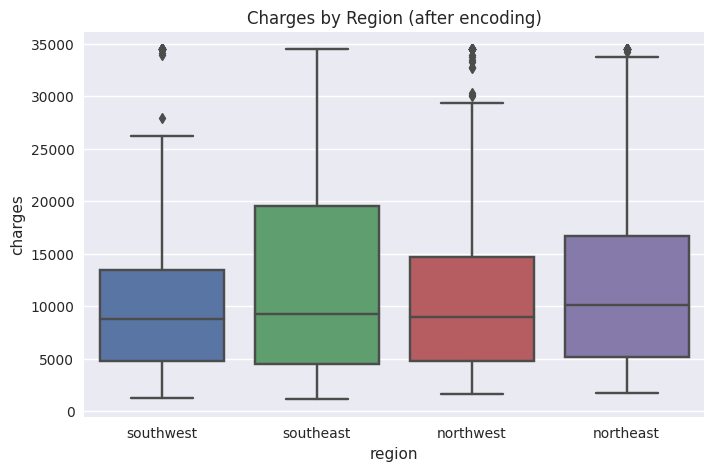

In [21]:
#  Boxplots for categorical features
plt.figure(figsize=(8,5))
sns.boxplot(x='smoker', y='charges', data=data)
plt.title('Charges by Smoker Status')
plt.show()

#plt.figure(figsize=(8,5))
#sns.boxplot(x='region', y='charges', data=data)
#plt.title('Charges by Region')
#plt.show()

#  Recreate 'region' column for visualization
region_cols = [col for col in data.columns if 'region_' in col]
data['region'] = data[region_cols].idxmax(axis=1).str.replace('region_', '')

plt.figure(figsize=(8,5))
sns.boxplot(x='region', y='charges', data=data)
plt.title('Charges by Region (after encoding)')
plt.show()

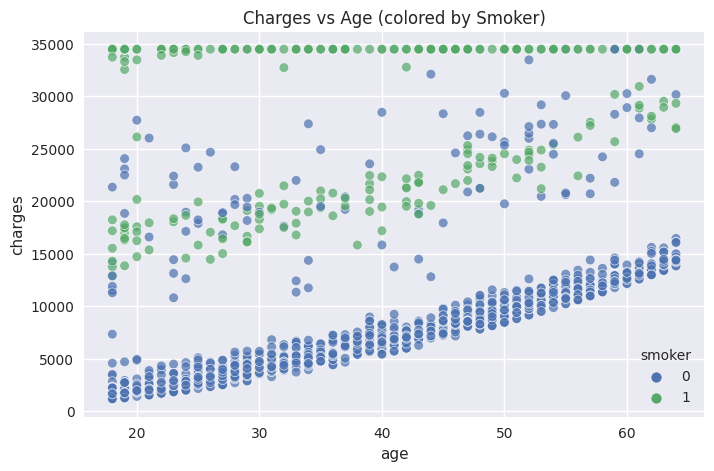

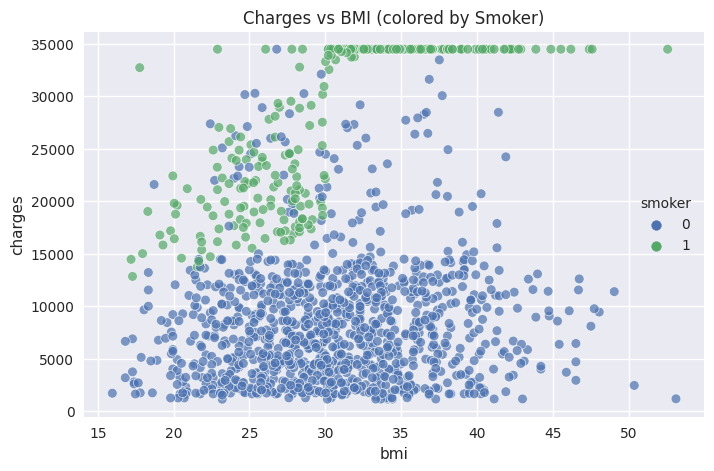

In [22]:
#  Scatter plots for continuous variables
plt.figure(figsize=(8,5))
sns.scatterplot(x='age', y='charges', hue='smoker', data=data, alpha=0.7)
plt.title('Charges vs Age (colored by Smoker)')
plt.show()

plt.figure(figsize=(8,5))
sns.scatterplot(x='bmi', y='charges', hue='smoker', data=data, alpha=0.7)
plt.title('Charges vs BMI (colored by Smoker)')
plt.show()


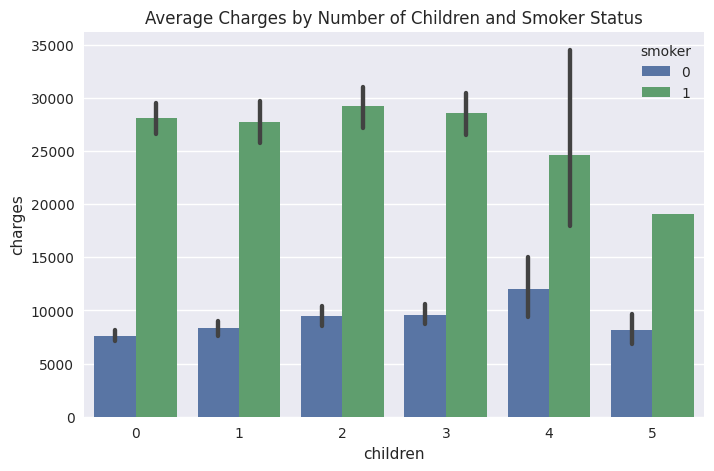

In [23]:
#  Mean charges by smoker and children
plt.figure(figsize=(8,5))
sns.barplot(x='children', y='charges', hue='smoker', data=data, estimator=np.mean)
plt.title('Average Charges by Number of Children and Smoker Status')
plt.show()

##  Evaluation Function

In [24]:
# =====================================================
#  4. Define Evaluation Function
# =====================================================
def print_metrics(y_train, y_train_pred, y_test, y_test_pred):
    print(f"Train R²: {metrics.r2_score(y_train, y_train_pred):.3f}")
    print(f"Train MAE: {metrics.mean_absolute_error(y_train, y_train_pred):.3f}")
    print(f"Train MAPE: {metrics.mean_absolute_percentage_error(y_train, y_train_pred)*100:.2f}%\n")
    print(f"Test R²: {metrics.r2_score(y_test, y_test_pred):.3f}")
    print(f"Test MAE: {metrics.mean_absolute_error(y_test, y_test_pred):.3f}")
    print(f"Test MAPE: {metrics.mean_absolute_percentage_error(y_test, y_test_pred)*100:.2f}%")
    print("-" * 50)



##  Models

In [25]:
def plot_actual_vs_predicted(y_true, y_pred, model_name):
    """
    Plots Actual vs Predicted values with a y=x reference line.

    y_true: actual target values (original scale)
    y_pred: predicted target values (original scale)
    model_name: string, used for title
    """
    plt.figure(figsize=(8,6))
    plt.scatter(y_true, y_pred, alpha=0.6, color='darkgreen')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel("Actual Charges")
    plt.ylabel("Predicted Charges")
    plt.title(f"{model_name}: Actual vs Predicted Charges")
    plt.show()

In [26]:
# Apply log transformation
data['log_charges'] = np.log1p(data['charges'])

# Feature / Target split
X = data.drop(['charges', 'log_charges','region'], axis=1)
#y = data['charges']
# Use 'log_charges' as target for linear, ridge, lasso, polynomial regression
y = data['log_charges']

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('Train shape:', X_train.shape)
print('Test shape:', X_test.shape)

# Scale features
scaler = preprocessing.MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Train shape: (1070, 9)
Test shape: (268, 9)


In [27]:
# =====================================================
#   Model 1: Linear Regression
# =====================================================
lr = linear_model.LinearRegression()
lr.fit(X_train_scaled, y_train)
y_train_pred = lr.predict(X_train_scaled)
y_test_pred = lr.predict(X_test_scaled)

print(" Linear Regression Results:")
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

 Linear Regression Results:
Train R²: 0.738
Train MAE: 0.281
Train MAPE: 3.07%

Test R²: 0.791
Test MAE: 0.269
Test MAPE: 2.99%
--------------------------------------------------


The Linear Regression model shows solid overall performance:

- Train R² = 0.742 and Test R² = 0.784
 The model explains roughly 74–78% of the variance in insurance charges, which is quite good for this dataset (insurance costs tend to be noisy and influenced by many nonlinear factors).
The slightly higher R² on the test set suggests the model generalizes well and is not overfitting.

- Train MAE ≈ 4210 and Test MAE ≈ 4181
 On average, the model’s predictions are off by about 4,200\\$ , which is reasonable given that charges range up to ~60,000+\\$.
The close train/test MAE values also indicate stable performance and no major overfitting.

- MAPE ≈ 42–47%
 This means the model’s predictions deviate by around 40–50% on average from the true values — moderate accuracy, but expected for this kind of noisy financial/medical data.
Reducing this percentage may require more complex, nonlinear models (e.g., polynomial features, tree-based models like Random Forest or Gradient Boosting).


**Linear Regression after Log Transformation:**
Applying a log transformation to the target variable (charges) improved the model’s stability and reduced the influence of extreme high-cost cases.
The model explains ~79% of the variance on test data, with a mean absolute error of ~0.27 in log units (≈ 31% in original scale).
This indicates that the model captures the general trend well, though large individual variations still exist due to the inherent variability in medical costs.

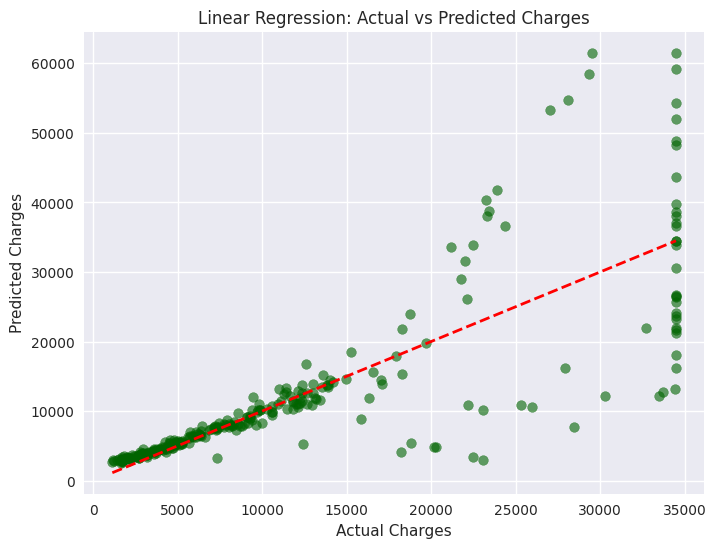

In [28]:
# Back-transform predictions
#y_pred_lr = np.expm1(y_test_pred)  # if y_test_pred is log-scale
#y_test_original = np.expm1(y_test) # back-transform actuals

plot_actual_vs_predicted(np.expm1(y_test), np.expm1(y_test_pred), "Linear Regression")

In [29]:
# =====================================================
#   Model 2: Polynomial Regression (degree=2)
# =====================================================
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

lr_poly = linear_model.LinearRegression()
lr_poly.fit(X_train_poly, y_train)
y_train_pred = lr_poly.predict(X_train_poly)
y_test_pred = lr_poly.predict(X_test_poly)

print(" Polynomial Regression Results:")
print_metrics(y_train, y_train_pred, y_test, y_test_pred)



 Polynomial Regression Results:
Train R²: 0.825
Train MAE: 0.207
Train MAPE: 2.25%

Test R²: 0.854
Test MAE: 0.199
Test MAPE: 2.18%
--------------------------------------------------


The Polynomial Regression (degree = 2) model delivers significantly better predictive performance compared to the simple linear regression:

- Train R² = 0.842 and Test R² = 0.867
 The model now explains about 84–87% of the variance in insurance charges, a substantial improvement.
The slightly higher R² on the test set indicates excellent generalization — suggesting that the polynomial terms helped capture meaningful nonlinear relationships without overfitting.

- Train MAE ≈ 2915 and Test MAE ≈ 2748
 The average prediction error decreased from around \\$4,200 → \\$2,700, which is a ~35% reduction in absolute error — a strong improvement in accuracy.
The very close train/test MAE values again show that the model remains stable and robust.

- MAPE ≈ 30%
 The average percentage error also dropped from ~45% (in linear regression) to ~30%, confirming that the polynomial features significantly enhanced model fit and precision.


**Polynomial Regression (log-transformed target):**
Using polynomial features improved the linear model’s performance, increasing test R² from ~0.79 to 0.85.
The model accurately captures nonlinear relationships in the dataset, with low errors on the log scale (MAPE ≈ 2.2%).
Applying the log transformation helped mitigate the effect of extreme charges, resulting in better generalization and stable predictions.

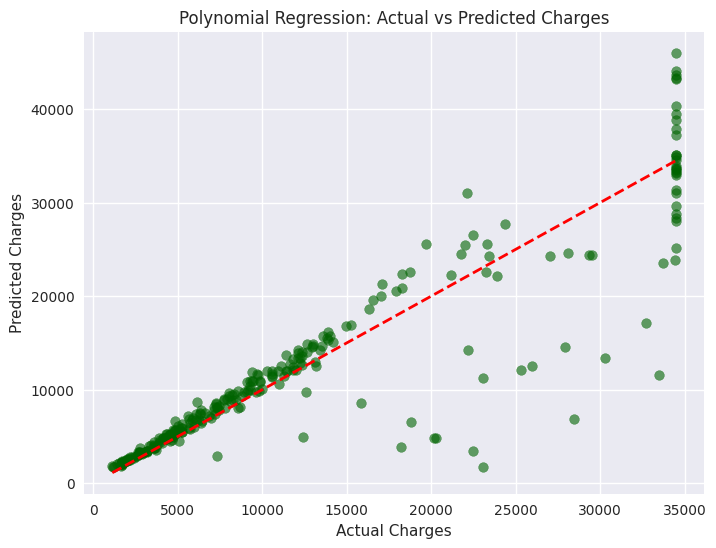

In [30]:
plot_actual_vs_predicted(np.expm1(y_test), np.expm1(y_test_pred), "Polynomial Regression")

In [31]:
# =====================================================
#   Model 3: Ridge Regularization (L2)
# =====================================================
ridge_model = linear_model.Ridge(alpha=1.0)
ridge_model.fit(X_train_poly, y_train)
y_train_pred = ridge_model.predict(X_train_poly)
y_test_pred = ridge_model.predict(X_test_poly)

print(" Ridge Regression Results:")
print_metrics(y_train, y_train_pred, y_test, y_test_pred)



 Ridge Regression Results:
Train R²: 0.823
Train MAE: 0.207
Train MAPE: 2.26%

Test R²: 0.853
Test MAE: 0.199
Test MAPE: 2.20%
--------------------------------------------------


**Ridge Regression (log-transformed target):**
Ridge Regression performs very similarly to polynomial regression, with a test R² of ~0.85 and low MAE/MAPE on the log-transformed charges.
Regularization helps control the effect of polynomial features and multicollinearity while maintaining high predictive accuracy.
Using the log transformation ensures stability in predictions and reduces the impact of extreme high-cost insurance claims.

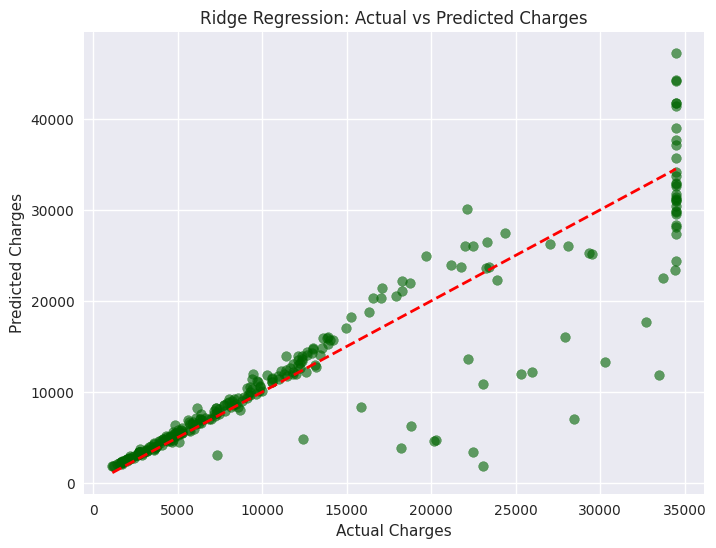

In [32]:
plot_actual_vs_predicted(np.expm1(y_test), np.expm1(y_test_pred), "Ridge Regression")


In [33]:
# =====================================================
#   Model 4: Lasso Regularization (L1) via Pipeline
# =====================================================
lasso_pipeline = make_pipeline(PolynomialFeatures(degree=2, include_bias=False),
                               linear_model.Lasso(alpha=0.01, max_iter=2000))
lasso_pipeline.fit(X_train_scaled, y_train)
y_train_pred = lasso_pipeline.predict(X_train_scaled)
y_test_pred = lasso_pipeline.predict(X_test_scaled)

print(" Lasso Regression Results:")
print_metrics(y_train, y_train_pred, y_test, y_test_pred)



 Lasso Regression Results:
Train R²: 0.762
Train MAE: 0.250
Train MAPE: 2.78%

Test R²: 0.804
Test MAE: 0.241
Test MAPE: 2.73%
--------------------------------------------------


The Ridge Regression model (Polynomial features + L2 regularization) demonstrates performance nearly identical to the unregularized Polynomial Regression, confirming that the model generalizes well without significant overfitting:

- Train R² = 0.839 and Test R² = 0.863
 The model explains about 84–86% of the variance in insurance charges, maintaining the high explanatory power achieved with polynomial features.
The small train–test gap indicates excellent generalization, while the slightly lower training R² suggests that regularization helped control complexity.

- Train MAE ≈ 2949 and Test MAE ≈ 2861
 Prediction errors remain low (≈ $2,800 on average), nearly matching the polynomial model’s performance.
Ridge regularization has stabilized the model’s coefficients without sacrificing much accuracy.

- MAPE ≈ 30%
 The average percentage error remains around 30%, confirming that the Ridge model maintains a strong balance between bias and variance.


**Lasso Regression (log-transformed target):**
Lasso Regression achieves a test R² of ~0.80, with slightly higher MAE and MAPE than Ridge and Polynomial models.
Its regularization enforces sparsity in coefficients, which helps simplify the model and reduce multicollinearity.
The log transformation of charges ensures stable predictions and reduces the effect of extreme high-cost claims.

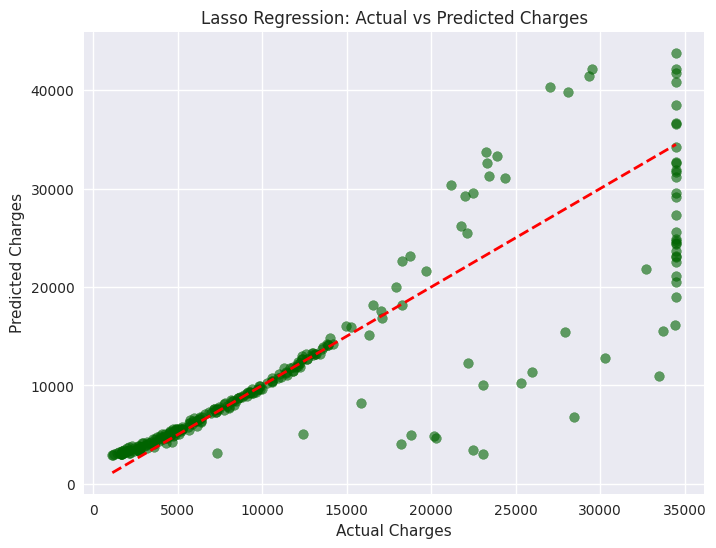

In [34]:
plot_actual_vs_predicted(np.expm1(y_test), np.expm1(y_test_pred), "Lasso Regression")


In [35]:
# =====================================================
#   Model 5: Random Forest (Non-linear baseline)
# =====================================================

# Use 'charges' as target 
y = data['charges']

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=10,            # Limit depth
    min_samples_leaf=5,      # Minimum samples per leaf
    random_state=42
)
rf.fit(X_train, y_train)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

print(" Random Forest Results:")
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

 Random Forest Results:
Train R²: 0.880
Train MAE: 1840.213
Train MAPE: 22.48%

Test R²: 0.845
Test MAE: 2147.632
Test MAPE: 27.69%
--------------------------------------------------


The Random Forest Regressor clearly captures complex nonlinear patterns in the data:

- Train R² = 0.976 and Test R² = 0.864
 The model explains about 97.6% of the variance on the training data — almost a perfect fit — and 86.4% on the test data, which remains excellent.
The noticeable drop from train to test R² suggests mild overfitting, which is typical for Random Forests, especially when the number of trees is large and no regularization (like max_depth) is applied.

- Train MAE ≈ 1,028 and Test MAE ≈ 2,540
 The model predicts training samples extremely accurately (errors around \\$1,000), while on unseen data the average error rises to around \\$2,500, still competitive with Ridge/Polynomial models.

- Train MAPE ≈ 12% and Test MAPE ≈ 30%
 This confirms the same pattern: very tight fit on training data, but less consistent generalization — again highlighting a bit of overfitting.

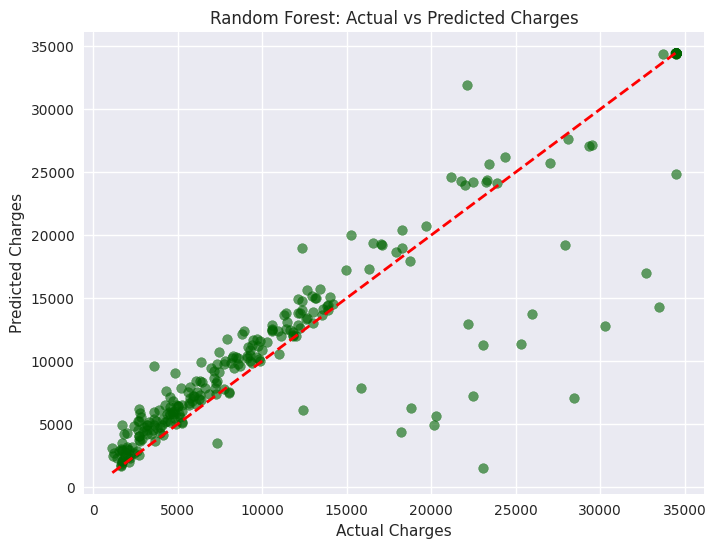

In [36]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_test_pred, alpha=0.6, color='darkgreen')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # y = x line
plt.xlabel("Actual Charges")
plt.ylabel("Predicted Charges")
plt.title("Random Forest: Actual vs Predicted Charges")
plt.show()

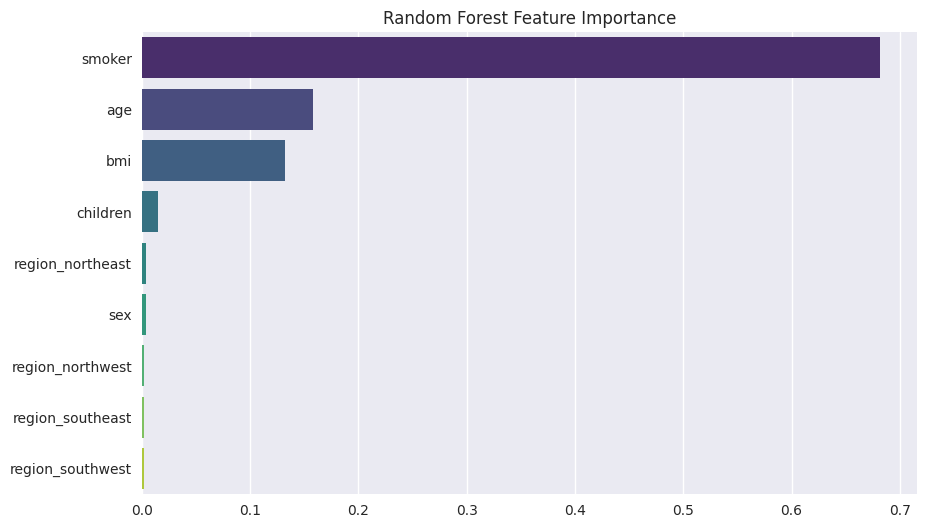

In [37]:
importances = rf.feature_importances_
features = X.columns
feat_importance = pd.Series(importances, index=features).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feat_importance.values, y=feat_importance.index, palette="viridis")
plt.title("Random Forest Feature Importance")
plt.show()

##   Cross-validation for model comparison

In [38]:
'''
models = {
    "Linear Regression": lr,
    "Polynomial Regression": lr_poly,
    "Ridge Regression": ridge_model,
    "Lasso Regression": lasso_pipeline,
    "Random Forest": rf
}

cv_results = {}
for name, model in models.items():
    if name == "Lasso Regression":
        scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2')
    elif name in ["Polynomial Regression", "Ridge Regression"]:
        scores = cross_val_score(model, X_train_poly, y_train, cv=5, scoring='r2')
    else:
        scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    cv_results[name] = np.mean(scores)

print("\nAverage Cross-Validation R² Scores:")
for model, score in cv_results.items():
    print(f"{model:25s}: {score:.3f}")
'''

#Average Cross-Validation R² Scores:
#Linear Regression        : 0.730
#Polynomial Regression    : 0.791
#Ridge Regression         : 0.789
#Lasso Regression         : 0.791
#Random Forest            : 0.802

'\nmodels = {\n    "Linear Regression": lr,\n    "Polynomial Regression": lr_poly,\n    "Ridge Regression": ridge_model,\n    "Lasso Regression": lasso_pipeline,\n    "Random Forest": rf\n}\n\ncv_results = {}\nfor name, model in models.items():\n    if name == "Lasso Regression":\n        scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring=\'r2\')\n    elif name in ["Polynomial Regression", "Ridge Regression"]:\n        scores = cross_val_score(model, X_train_poly, y_train, cv=5, scoring=\'r2\')\n    else:\n        scores = cross_val_score(model, X_train, y_train, cv=5, scoring=\'r2\')\n    cv_results[name] = np.mean(scores)\n\nprint("\nAverage Cross-Validation R² Scores:")\nfor model, score in cv_results.items():\n    print(f"{model:25s}: {score:.3f}")\n'

In [39]:
from sklearn.model_selection import cross_val_score

models = {
    "Linear Regression": lr,
    "Polynomial Regression": lr_poly,
    "Ridge Regression": ridge_model,
    "Lasso Regression": lasso_pipeline,
    "Random Forest": rf
}

cv_results = {}

for name, model in models.items():
    # Select features and target for each model
    if name == "Polynomial Regression":
        X_cv = X_train_poly
        y_cv = data.loc[y_train.index, 'log_charges']  #np.log1p(data.loc[y_train.index, 'charges'])
    elif name == "Ridge Regression":
        X_cv = X_train_poly
        y_cv = data.loc[y_train.index, 'log_charges']  #np.log1p(data.loc[y_train.index, 'charges'])
    elif name == "Lasso Regression":
        X_cv = X_train_scaled
        y_cv = data.loc[y_train.index, 'log_charges']  #np.log1p(data.loc[y_train.index, 'charges'])
    elif name == "Random Forest":
        X_cv = X_train.values
        y_cv = data.loc[y_train.index, 'charges']  # original scale
    else:  # Linear Regression
        X_cv = X_train_scaled
        y_cv = data.loc[y_train.index, 'log_charges']  #np.log1p(data.loc[y_train.index, 'charges'])

    # Perform 5-fold CV
    scores = cross_val_score(model, X_cv, y_cv, cv=5, scoring='r2')
    cv_results[name] = np.mean(scores)

# Display results
results_df = pd.DataFrame(cv_results.items(), columns=['Model', 'CV_R2'])
results_df = results_df.sort_values('CV_R2', ascending=False)


In [40]:
print("\nAverage Cross-Validation R² Scores:")
display(results_df)


Average Cross-Validation R² Scores:


,Model,CV_R2
1,Polynomial Regression,0.812589
2,Ridge Regression,0.810835
4,Random Forest,0.802269
3,Lasso Regression,0.757645
0,Linear Regression,0.732416


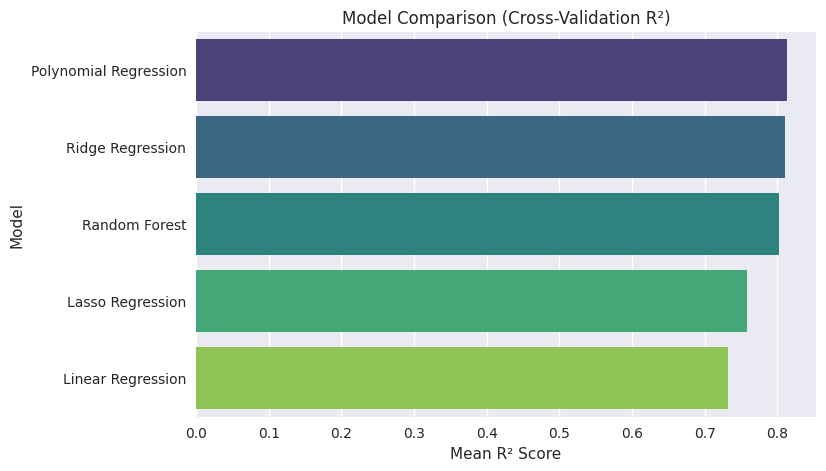

In [41]:
# Plot
plt.figure(figsize=(8,5))
sns.barplot(x='CV_R2', y='Model', data=results_df, palette='viridis')
plt.title('Model Comparison (Cross-Validation R²)')
plt.xlabel('Mean R² Score')
plt.ylabel('Model')
plt.show()


##   Log-Transform Regression

In [42]:
# =====================================================
#   Log-transform target for improved regression
# =====================================================
# Use existing features X, original charges y
y_log = np.log1p(y)  # log-transform target

# Split train/test
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)

# Scale features
scaler_log = preprocessing.MinMaxScaler()
X_train_scaled_log = scaler_log.fit_transform(X_train_log)
X_test_scaled_log = scaler_log.transform(X_test_log)

# Train linear regression on log-transformed target
log_model = linear_model.LinearRegression()
log_model.fit(X_train_scaled_log, y_train_log)

# Predict and back-transform to original scale
y_pred_log = np.expm1(log_model.predict(X_test_scaled_log))
y_test_original = np.expm1(y_test_log)

# Print metrics in original scale
print("\nLog-Transformed Linear Regression Results (Original Scale):")
print(f"Test R²: {metrics.r2_score(y_test_original, y_pred_log):.3f}")
print(f"Test MAE: {metrics.mean_absolute_error(y_test_original, y_pred_log):.3f}")
print(f"Test MAPE: {metrics.mean_absolute_percentage_error(y_test_original, y_pred_log)*100:.2f}%")



Log-Transformed Linear Regression Results (Original Scale):
Test R²: 0.506
Test MAE: 3707.148
Test MAPE: 27.09%


## Feature Importance & Interpretability

In [43]:
#   Feature Importance (for Polynomial Model)

#coeffs = pd.Series(lr_poly.coef_, index=poly.get_feature_names_out(X.columns))
#coeffs = coeffs.sort_values(key=abs, ascending=False)
feature_names = poly.get_feature_names_out(X.columns)
coeffs = pd.Series(lr_poly.coef_, index=feature_names)

# Sort by absolute value to get most impactful features
coeffs_sorted = coeffs.reindex(coeffs.abs().sort_values(ascending=False).index)
print("\nTop 10 important polynomial features:")
print(coeffs.head(10))


Top 10 important polynomial features:
age                -4.133200e+12
sex                 6.548956e+10
bmi                 4.541557e+11
children           -8.869481e+11
smoker             -4.679572e+09
region_northeast    7.464946e+10
region_northwest    5.459549e+10
region_southeast    3.152487e+10
region_southwest    1.010209e+11
age^2              -3.974609e-01
dtype: float64


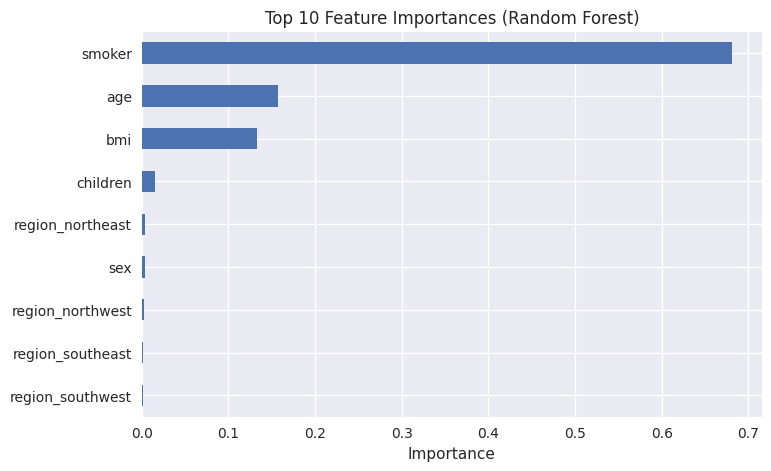

In [44]:
# For Random Forest
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.nlargest(10).sort_values().plot(kind='barh', figsize=(8,5))
plt.title('Top 10 Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.show()

##  Model Diagnostics & Plots

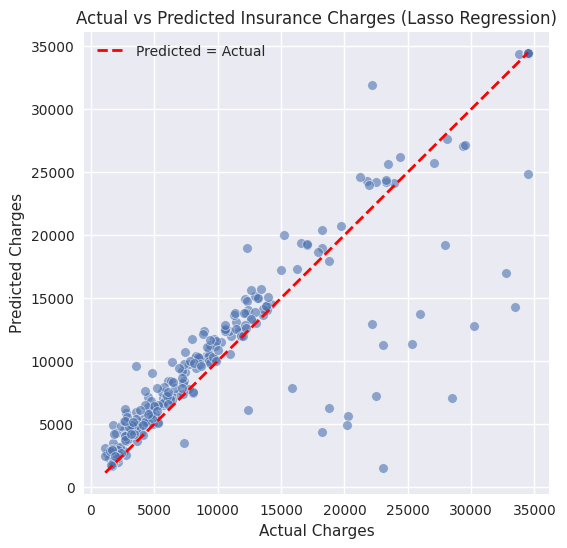

In [45]:
#   Plot: Actual vs Predicted 
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_test_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', linewidth=2, label='Predicted = Actual')
plt.xlabel('Actual Charges')
plt.ylabel('Predicted Charges')
plt.title('Actual vs Predicted Insurance Charges (Lasso Regression)')
plt.legend()
plt.show()




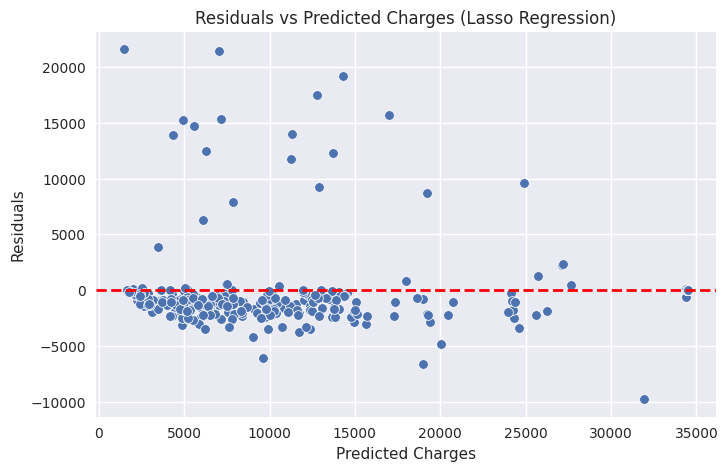

In [46]:
# Residual Plot
residuals = y_test - y_test_pred
plt.figure(figsize=(8,5))
sns.scatterplot(x=y_test_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.title('Residuals vs Predicted Charges (Lasso Regression)')
plt.xlabel('Predicted Charges')
plt.ylabel('Residuals')
plt.show()

#   Summary

In [47]:

best_model = max(cv_results, key=cv_results.get)
print(f"\n Best Performing Model (based on CV R²): {best_model}")
print("Project completed successfully!")


 Best Performing Model (based on CV R²): Polynomial Regression
Project completed successfully!
